### Title

# Fake News Detection

### Overview of Problem Statement


##### Fake news has become a critical issue with the rise of online platforms. The spread of misinformation can mislead the public and create social, political, or economic consequences. Detecting and classifying fake news is therefore a significant challenge in Natural Language Processing (NLP).

### Objective



##### The main objective of this project is to develop a deep learning-based classifier that can accurately distinguish between Fake and Real news articles based on their textual content.

### Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Step 2: Load Dataset
df = pd.read_csv('news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


### Data Cleaning

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(inplace=True)
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,title,text,label,text_length
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,1296
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,446
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,431
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,404
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,317


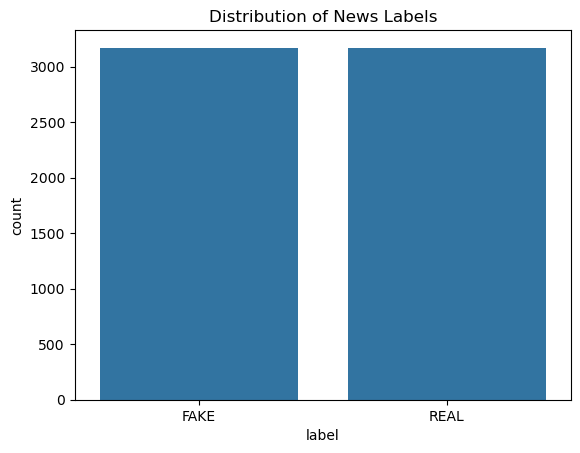

In [4]:
#  EDA - Label Distribution
sns.countplot(data=df, x='label')
plt.title('Distribution of News Labels')
plt.show()

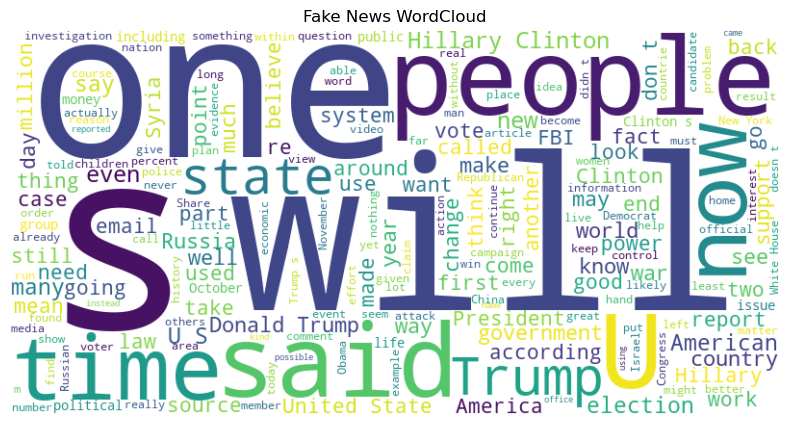

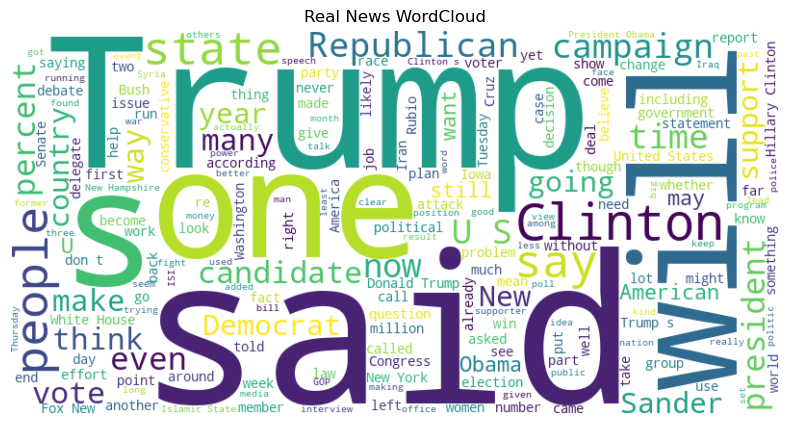

In [5]:
#  EDA - Word Cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_wordcloud(df[df['label'] == 'FAKE']['text'], 'Fake News WordCloud')
generate_wordcloud(df[df['label'] == 'REAL']['text'], 'Real News WordCloud')

### Encoding label

In [6]:
#  Preprocessing
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [7]:
X = df['text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
tokenizer = Tokenizer(num_words=6000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=500)
X_test_pad = pad_sequences(X_test_seq, maxlen=500)

In [9]:
# Optimized LSTM Model
model = Sequential([
    Embedding(input_dim=6000, output_dim=128, input_length=500),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stop])

Epoch 1/10


G:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6403 - loss: 0.6455 - val_accuracy: 0.8028 - val_loss: 0.4589
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8727 - loss: 0.3258 - val_accuracy: 0.8698 - val_loss: 0.3187
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9427 - loss: 0.1690 - val_accuracy: 0.8895 - val_loss: 0.2949
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9869 - loss: 0.0576 - val_accuracy: 0.8600 - val_loss: 0.3980
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9908 - loss: 0.0387 - val_accuracy: 0.8698 - val_loss: 0.4606


In [10]:
# Model Evaluation
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step
Accuracy: 0.8997632202052092
              precision    recall  f1-score   support

        FAKE       0.91      0.88      0.90       628
        REAL       0.89      0.92      0.90       639

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



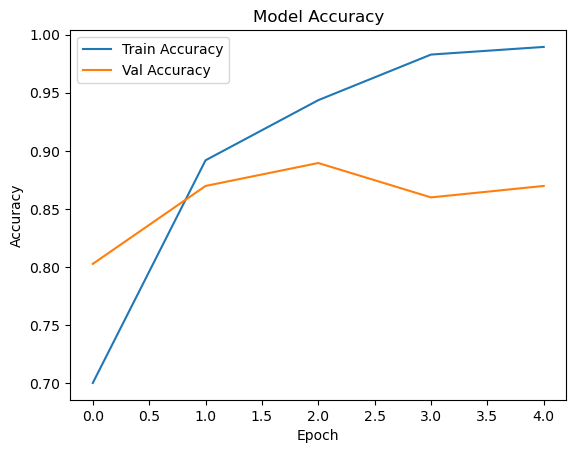

In [11]:
# Accuracy Over Epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Input news
X = "Karry to go to France in gesture of sympathy"

# Define padding and truncation types
padding_type = 'post'
trunc_type = 'post'

# Convert input to sequence
sequences = tokenizer.texts_to_sequences([X])
padded = pad_sequences(sequences, maxlen=500, padding=padding_type, truncating=trunc_type)

# Predict using the model
prediction = model.predict(padded, verbose=0)[0][0]

# Interpret result
if prediction >= 0.5:
    print("This news is True (REAL)")
else:
    print("This news is False (FAKE)")


This news is False (FAKE)


### Results



Accuracy: ~90% (based on evaluation in notebook).

Classification Report: Balanced precision, recall, and F1-scores for both Fake and Real labels.

Training Curve: Accuracy improved steadily, validation stabilized after early stopping.

### Conclusion



The Bidirectional LSTM model effectively classifies Fake vs Real news with high accuracy. The project demonstrates the potential of deep learning for fake news detection in NLP